In [1]:
from PIL import Image
import numpy as np

import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import requests
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\mmoustafa/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:28<00:00, 20.5MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [83]:
for name in vgg._modules.keys():
    print("module:" + str(name))
    print(vgg._modules[name])
    print("")

module:0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:1
ReLU(inplace=True)

module:2
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:3
ReLU(inplace=True)

module:4
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

module:5
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:6
ReLU(inplace=True)

module:7
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:8
ReLU(inplace=True)

module:9
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

module:10
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:11
ReLU(inplace=True)

module:12
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:13
ReLU(inplace=True)

module:14
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

module:15
ReLU(inplace=True)

module:16
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

mo

In [8]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [59]:
content = load_image('images/style.jpg').to(device)
style = load_image('images/star.jpg', shape=content.shape[-2:]).to(device)

In [60]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

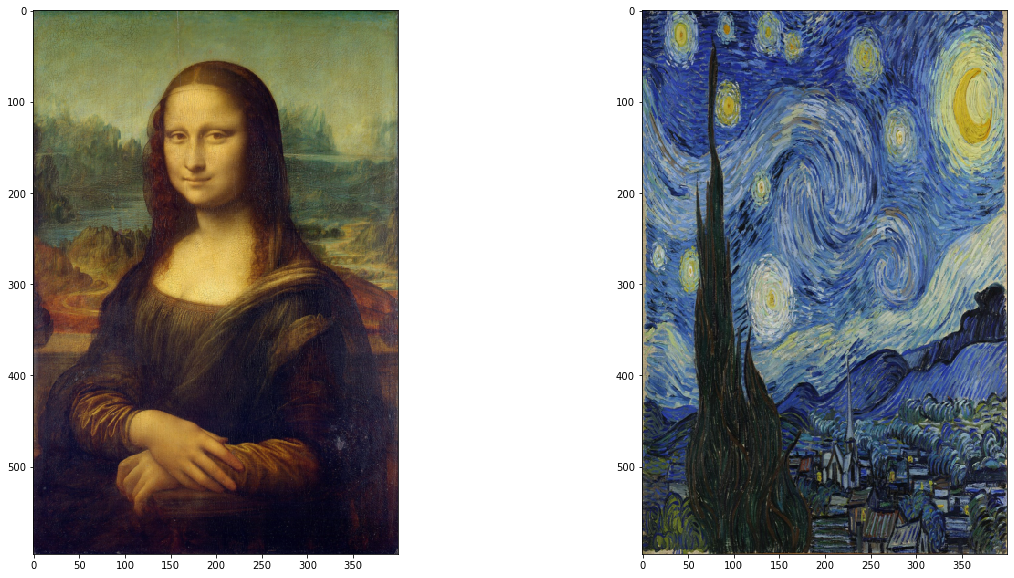

In [61]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [62]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1',
                 '34': 'conv8_512'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [63]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [64]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [68]:
style_weights = {'conv1_1':1.,
                 'conv2_1':0.75,
                 'conv3_1':0.5,
                 'conv4_1':0.3,
                 'conv4_2':0.2,
                 'conv5_1':0.2,
                 'conv8_512':0.1}

content_weight = 1 #alpha
style_weight = 1e6 #beta

<h2><b>Train Network</b></h2>


Total loss:  52902.85546875


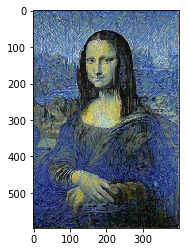

Total loss:  49505.96875


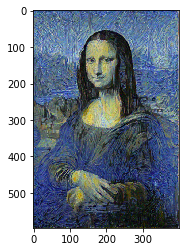

Total loss:  46974.48046875


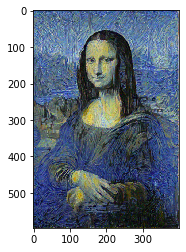

Total loss:  45047.69140625


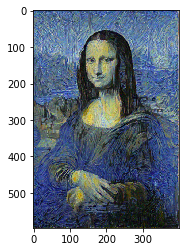

Total loss:  43625.71484375


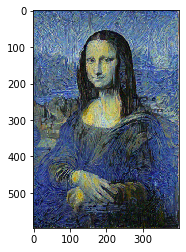

Total loss:  42343.85546875


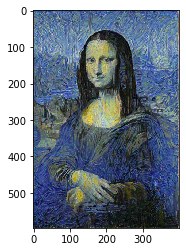

Total loss:  41342.12109375


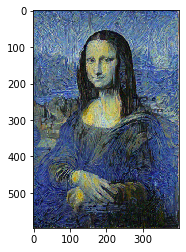

Total loss:  40688.6015625


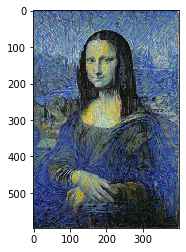

Total loss:  40518.640625


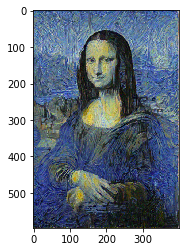

Total loss:  39271.44921875


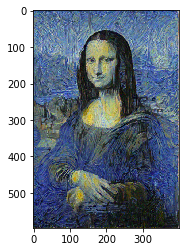

In [69]:
show_every = 1000

optimizer = torch.optim.Adam([target], lr=0.003)
steps = 10000

for ii in range(1, steps+1):
    #get target image features
    target_features = get_features(target, vgg)
    
    #get content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    #init style loss as 0
    style_loss = 0
    
    #then add to it for each layer's gram matrix loss
    for layer in style_weights:
        #get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _,d,h,w = target_feature.shape
        #get the "style" style representation
        style_gram = style_grams[layer]
        #the style loss for one layer, weighted appropriatly
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        #add to the style loss
        style_loss += layer_style_loss/(d*h*w)
        
    total_loss = content_weight*content_loss + style_weight*style_loss
    
    #update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii%show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

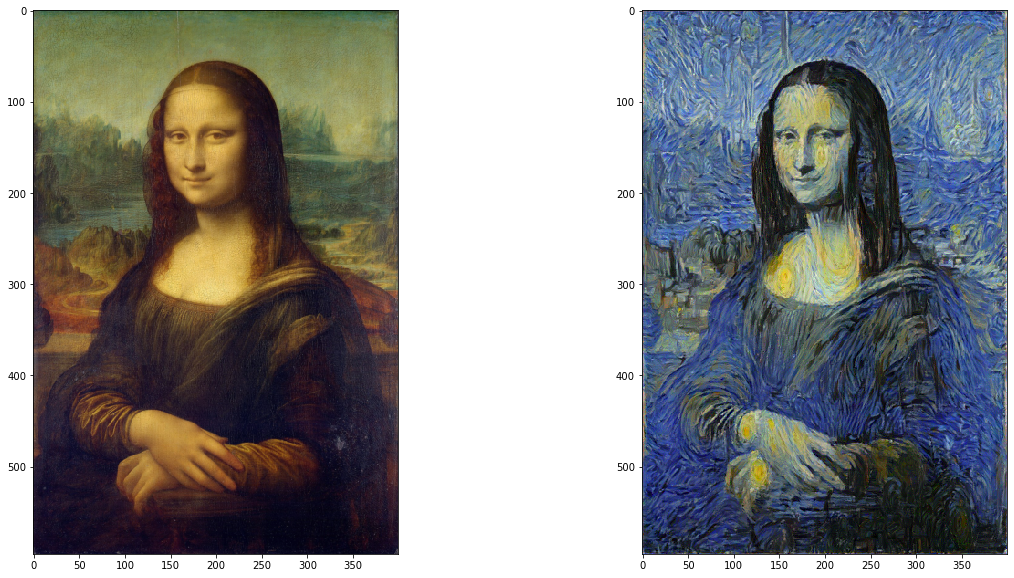

In [70]:
#display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

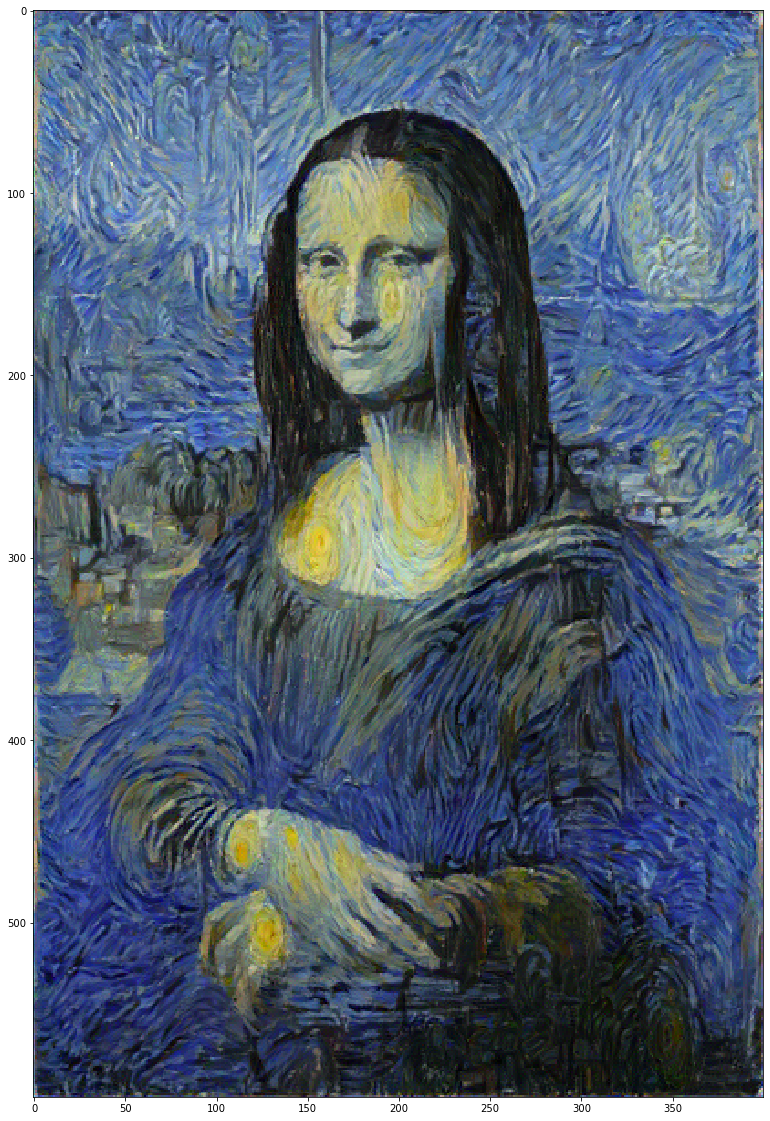

In [81]:
#display content and final, target image
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(im_convert(target))